# 特徴量作成 1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import datetime
import os
import calendar
from tqdm.notebook import tqdm
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import utils

In [4]:
import sys
sys.path.append("../common")
import common_utils

In [5]:
IN_DIRECTORY = '../data/processed'
# OUT_DIRECTORY = './processed'

In [6]:
# os.makedirs(OUT_DIRECTORY, exist_ok=True)

## 準備

In [7]:
symbol = "usdjpy"
year_from = 2019
month_from = 10
year_to = 2019
month_to = 12

In [8]:
df_org = utils.read_processed_data_range(symbol, year_from, month_from, year_to, month_to)

In [9]:
assert (df_org.index[0].hour, df_org.index[0].minute) == (0, 0)
assert (df_org.index[-1].hour, df_org.index[-1].minute) == (23, 59)

In [10]:
df_org.head()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close
timestamp,,,,,,,,
2019-10-01 00:00:00,108.071,108.074,108.071,108.074,108.095,108.099,108.089,108.098
2019-10-01 00:01:00,108.075,108.075,108.071,108.072,108.098,108.099,108.098,108.099
2019-10-01 00:02:00,108.074,108.074,108.071,108.071,108.098,108.098,108.098,108.098
2019-10-01 00:03:00,108.071,108.072,108.071,108.072,108.101,108.101,108.098,108.098
2019-10-01 00:04:00,108.077,108.077,108.077,108.077,108.094,108.094,108.094,108.094


In [11]:
df_org.tail()

,bid_open,bid_high,bid_low,bid_close,ask_open,ask_high,ask_low,ask_close
timestamp,,,,,,,,
2019-12-31 23:55:00,108.643,108.655,108.643,108.653,108.654,108.661,108.652,108.660
2019-12-31 23:56:00,108.659,108.669,108.659,108.666,108.661,108.677,108.661,108.672
2019-12-31 23:57:00,108.668,108.675,108.665,108.667,108.673,108.682,108.673,108.679
2019-12-31 23:58:00,108.667,108.673,108.619,108.619,108.678,108.685,108.676,108.685
2019-12-31 23:59:00,108.619,108.631,108.613,108.631,108.683,108.684,108.680,108.683


In [91]:
df = pd.DataFrame({
    "open": (df_org["bid_open"] + df_org["ask_open"]) / 2,
    "high": (df_org["bid_high"] + df_org["ask_high"]) / 2,
    "low": (df_org["bid_low"] + df_org["ask_low"]) / 2,
    "close": (df_org["bid_close"] + df_org["ask_close"]) / 2,
}, index=df_org.index)

In [92]:
df = df.add_suffix("_1min")

In [93]:
df.head()

,open_1min,high_1min,low_1min,close_1min
timestamp,,,,
2019-10-01 00:00:00,108.0830,108.0865,108.0800,108.0860
2019-10-01 00:01:00,108.0865,108.0870,108.0845,108.0855
2019-10-01 00:02:00,108.0860,108.0860,108.0845,108.0845
2019-10-01 00:03:00,108.0860,108.0865,108.0845,108.0850
2019-10-01 00:04:00,108.0855,108.0855,108.0855,108.0855


## 調整

In [118]:
freqs = ["1min", "5min", "15min", "30min", "1h", "4h", "1d"]

In [119]:
freq = "1min"
# threshold_frac = 0.1
threshold_frac = 0.05
tolerance_coef = 2.0

In [120]:
if freq == "1min":
    df_agg = df.copy()
else:
    df_agg = pd.concat({
        f"open_{freq}": utils.aggregate_time(df["open_1min"], freq, how="first"),
        f"high_{freq}": utils.aggregate_time(df["high_1min"], freq, how="max"),
        f"low_{freq}": utils.aggregate_time(df["low_1min"], freq, how="min"),
        f"close_{freq}": utils.aggregate_time(df["close_1min"], freq, how="last"),
    }, axis=1)

In [121]:
shifted_ma = df_agg[f"open_{freq}"].rolling(10).mean().shift(1)
residual = df_agg[f"open_{freq}"] - shifted_ma
residual_scale = (residual ** 2).mean() ** 0.5
residual_scale

0.016509333783491446

In [122]:
approx_tolerance = residual_scale * tolerance_coef
approx_tolerance

0.03301866756698289

In [123]:
approx_high, slope_high = utils.polyline_approx(df_agg[f"high_{freq}"].values, tol=approx_tolerance, lookahead_max=15)
approx_low, slope_low = utils.polyline_approx(df_agg[f"low_{freq}"].values, tol=approx_tolerance, lookahead_max=15)

In [124]:
print("mean polyline length")
1 / np.mean(slope_high[1:] != slope_high[:-1]), 1 / np.mean(slope_low[1:] != slope_low[:-1])

mean polyline length


(13.154447702834801, 13.139768447482215)

In [125]:
threshold_slope = (
    np.nanquantile(np.minimum(slope_high, slope_low), 1-threshold_frac)
    - np.nanquantile(np.maximum(slope_high, slope_low), threshold_frac)
) * 0.5
threshold_slope

0.002303571428571262

In [126]:
uptrend = (slope_high > threshold_slope) & (slope_low > threshold_slope)
downtrend = (slope_high < -threshold_slope) & (slope_low < -threshold_slope)
print("uptrend ratio: ", uptrend.mean())
print("downtrend ratio: ", downtrend.mean())

uptrend ratio:  0.04921443736730361
downtrend ratio:  0.05087048832271762


In [131]:
start_datetime = "2019-11-01 00:00:00"
end_datetime = "2019-11-01 23:59:59"
df_plot = pd.DataFrame({
    "high": df_agg[f"high_{freq}"],
    "low": df_agg[f"low_{freq}"],
    "approx_high": approx_high,
    "approx_low": approx_low,
    "uptrend": uptrend,
    "downtrend": downtrend,
}).loc[start_datetime:end_datetime]

In [132]:
df_plot.head()

,high,low,approx_high,approx_low,uptrend,downtrend
timestamp,,,,,,
2019-11-01 00:00:00,108.0390,108.0300,108.032071,108.031929,False,False
2019-11-01 00:01:00,108.0390,108.0345,108.032607,108.034464,False,False
2019-11-01 00:02:00,108.0400,108.0370,108.033143,108.037000,False,False
2019-11-01 00:03:00,108.0405,108.0355,108.033679,108.036964,False,False
2019-11-01 00:04:00,108.0430,108.0345,108.034214,108.036929,False,False


In [133]:
def plot_bool_series(fig, s: pd.Series, fillcolor: str):
    v = s.values
    start_idxs = np.nonzero((~v[:-1]) & v[1:])[0] + 1
    end_idxs = np.nonzero(v[:-1] & (~v[1:]))[0] + 1
    if v[0]:
        start_idxs = [0, *start_idxs]
    if v[-1]:
        end_idxs = [*end_idxs, len(v) - 1]

    assert len(start_idxs) == len(end_idxs)

    for si, ei in zip(start_idxs, end_idxs):
        fig.add_vrect(x0=s.index[si], x1=s.index[ei], line_width=0, opacity=0.2, fillcolor=fillcolor)

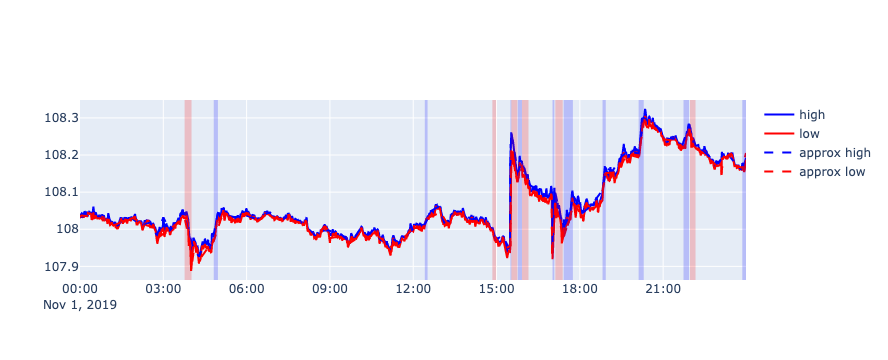

In [134]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot["high"], name="high", line=dict(color="blue")))
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot["low"], name="low", line=dict(color="red")))
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot["approx_high"], name="approx high", line=dict(color="blue", dash="dash")))
fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot["approx_low"], name="approx low", line=dict(color="red", dash="dash")))

plot_bool_series(fig, df_plot["uptrend"], fillcolor="blue")
plot_bool_series(fig, df_plot["downtrend"], fillcolor="red")
fig.show()

## ラベル作成

### トレンド判定

In [94]:
freqs = ["1min", "5min", "15min", "30min", "1h", "4h", "1d"]
trend_target_frac = 0.05
approx_tolerance_coef = 2.0

In [95]:
# for freq, tp in zip(freqs, threshold_pips):
for freq in freqs:
    print(f"freq = {freq}")

    # threshold = tp / 100 / lookahead
    # threshold = tp / 100
    # threshold_slope = threshold / lookahead
    # print(f"threshold = {threshold}")

    if freq == "1min":
        df_agg = df.copy()
    else:
        df_agg = pd.concat({
            f"open_{freq}": utils.aggregate_time(df["open_1min"], freq, how="first"),
            f"high_{freq}": utils.aggregate_time(df["high_1min"], freq, how="max"),
            f"low_{freq}": utils.aggregate_time(df["low_1min"], freq, how="min"),
            f"close_{freq}": utils.aggregate_time(df["close_1min"], freq, how="last"),
        }, axis=1)
    
    shifted_ma = df_agg[f"open_{freq}"].rolling(10).mean().shift(1)
    residual = df_agg[f"open_{freq}"] - shifted_ma
    residual_scale = (residual ** 2).mean() ** 0.5
    print(f"residual_scale = {residual_scale}")

    tolerance = residual_scale * approx_tolerance_coef
    print(f"tolerance = {tolerance}")
    approx_high, slope_high = utils.polyline_approx(df_agg[f"high_{freq}"].values, tol=tolerance, lookahead_max=15)
    approx_low, slope_low = utils.polyline_approx(df_agg[f"low_{freq}"].values, tol=tolerance, lookahead_max=15)

    threshold_slope = (
        np.nanquantile(np.minimum(slope_high, slope_low), 1-trend_target_frac)
        - np.nanquantile(np.maximum(slope_high, slope_low), trend_target_frac)
    ) * 0.5
    print(f"threshold_slope = {threshold_slope}")

    uptrend = (slope_high > threshold_slope) & (slope_low > threshold_slope)
    downtrend = (slope_high < -threshold_slope) & (slope_low < -threshold_slope)
    print("uptrend ratio: ", uptrend.mean())
    print("downtrend ratio: ", downtrend.mean())
    
    # continuous_uptrend = (pd.Series(uptrend).rolling(lookahead).sum().shift(-lookahead+1) == lookahead).values
    # continuous_downtrend = (pd.Series(downtrend).rolling(lookahead).sum().shift(-lookahead+1) == lookahead).values

    df_agg[f"uptrend_{freq}"] = uptrend
    df_agg[f"downtrend_{freq}"] = downtrend
    # df_agg[f"continuous_uptrend_{freq}"] = continuous_uptrend
    # df_agg[f"continuous_downtrend_{freq}"] = continuous_downtrend

    if freq == "1min":
        df_to_add = df_agg[["uptrend_1min", "downtrend_1min"]]
        # df_to_add = df_agg[["uptrend_1min", "downtrend_1min", "continuous_uptrend_1min", "continuous_downtrend_1min"]]
    else:
        df_to_add = df_agg.reindex(df.index, method="ffill")

    df = pd.concat([df, df_to_add], axis=1)

freq = 1min
residual_scale = 0.016509333783491446
tolerance = 0.03301866756698289
threshold_slope = 0.002303571428571262
uptrend ratio:  0.04921443736730361
downtrend ratio:  0.05087048832271762
freq = 5min
residual_scale = 0.03542094779389964
tolerance = 0.07084189558779928
threshold_slope = 0.004964285714286072
uptrend ratio:  0.05185774946921444
downtrend ratio:  0.04761146496815287
freq = 15min
residual_scale = 0.06030843679489915
tolerance = 0.1206168735897983
threshold_slope = 0.009678571428571456
uptrend ratio:  0.04856687898089172
downtrend ratio:  0.05079617834394905
freq = 30min
residual_scale = 0.0865804011138131
tolerance = 0.1731608022276262
threshold_slope = 0.01212987012986996
uptrend ratio:  0.04713375796178344
downtrend ratio:  0.05318471337579618
freq = 1h
residual_scale = 0.12330803385481852
tolerance = 0.24661606770963704
threshold_slope = 0.021563131313131353
uptrend ratio:  0.055414012738853505
downtrend ratio:  0.034394904458598725
freq = 4h
residual_scale = 0.24

In [96]:
df.head()

,open_1min,high_1min,low_1min,close_1min,uptrend_1min,downtrend_1min,open_5min,high_5min,low_5min,close_5min,...,low_4h,close_4h,uptrend_4h,downtrend_4h,open_1d,high_1d,low_1d,close_1d,uptrend_1d,downtrend_1d
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-10-01 00:00:00,108.0830,108.0865,108.0800,108.0860,True,False,108.083,108.087,108.08,108.0855,...,108.0425,108.146,False,True,108.083,108.471,107.6275,107.7485,False,True
2019-10-01 00:01:00,108.0865,108.0870,108.0845,108.0855,True,False,108.083,108.087,108.08,108.0855,...,108.0425,108.146,False,True,108.083,108.471,107.6275,107.7485,False,True
2019-10-01 00:02:00,108.0860,108.0860,108.0845,108.0845,True,False,108.083,108.087,108.08,108.0855,...,108.0425,108.146,False,True,108.083,108.471,107.6275,107.7485,False,True
2019-10-01 00:03:00,108.0860,108.0865,108.0845,108.0850,True,False,108.083,108.087,108.08,108.0855,...,108.0425,108.146,False,True,108.083,108.471,107.6275,107.7485,False,True
2019-10-01 00:04:00,108.0855,108.0855,108.0855,108.0855,True,False,108.083,108.087,108.08,108.0855,...,108.0425,108.146,False,True,108.083,108.471,107.6275,107.7485,False,True


In [97]:
df.columns

Index(['open_1min', 'high_1min', 'low_1min', 'close_1min', 'uptrend_1min',
       'downtrend_1min', 'open_5min', 'high_5min', 'low_5min', 'close_5min',
       'uptrend_5min', 'downtrend_5min', 'open_15min', 'high_15min',
       'low_15min', 'close_15min', 'uptrend_15min', 'downtrend_15min',
       'open_30min', 'high_30min', 'low_30min', 'close_30min', 'uptrend_30min',
       'downtrend_30min', 'open_1h', 'high_1h', 'low_1h', 'close_1h',
       'uptrend_1h', 'downtrend_1h', 'open_4h', 'high_4h', 'low_4h',
       'close_4h', 'uptrend_4h', 'downtrend_4h', 'open_1d', 'high_1d',
       'low_1d', 'close_1d', 'uptrend_1d', 'downtrend_1d'],
      dtype='object')

In [98]:
(df.isnull().sum() == 0).all()

True

### ラベル付け

- entry

    トレンドがある程度継続するかで判断.  
    長期間で上昇する場合も, 短期間で下落するならそれから買った方が良い.  
    結局短期間だけを見て判断すれば良い.

- exit

    短い時間足から見ていき, 先に上昇トレンドが現れなければ買いポジションを決済

In [99]:
lookahead = 5

In [100]:
df["long_entry"] = df["uptrend_1min"].rolling(lookahead).sum().shift(-lookahead+1) == lookahead
df["short_entry"] = df["downtrend_1min"].rolling(lookahead).sum().shift(-lookahead+1) == lookahead

In [101]:
trend_first = pd.Series(np.zeros(len(df)), index=df.index)
for freq in freqs:
    trend_first[(trend_first == 0) & df[f"uptrend_{freq}"]] = 1
    trend_first[(trend_first == 0) & df[f"downtrend_{freq}"]] = -1

# continuous_trend_first = pd.Series(np.zeros(len(df)), index=df.index)
# for freq in freqs:
#     continuous_trend_first[(continuous_trend_first == 0) & df[f"continuous_uptrend_{freq}"]] = 1
#     continuous_trend_first[(continuous_trend_first == 0) & df[f"continuous_downtrend_{freq}"]] = -1

In [102]:
df["long_exit"] = (trend_first != 1)
df["short_exit"] = (trend_first != -1)

In [103]:
df[["long_entry", "short_entry"]].mean()

long_entry     0.030021
short_entry    0.032038
dtype: float64

In [104]:
df[["long_exit", "short_exit"]].mean()

long_exit     0.821263
short_exit    0.763864
dtype: float64

In [105]:
assert not (df["long_entry"] & df["long_exit"]).any()
assert not (df["short_entry"] & df["short_exit"]).any()

## 実績シミュレーション

In [106]:
loss_cut_threshold = 0.05

In [107]:
order_manager = common_utils.OrderManager()

for i in range(len(df)):
    timestamp = df.index[i]
    
    if not order_manager.has_position():
        # 厳し目の見積もりをする
        current_rate_long = df["high_1min"][i]
        current_rate_short = df["low_1min"][i]

        if df["long_entry"][i]:
            order_manager.entry("long", timestamp, current_rate_long)
            print(timestamp, "long entry")
        elif df["short_entry"][i]:
            order_manager.entry("short", timestamp, current_rate_short)
            print(timestamp, "short entry")
    else:
        end_of_day = (timestamp.hour, timestamp.minute) == (23, 59)

        # 厳し目の見積もりをする
        current_rate_long = df["low_1min"][i]
        current_rate_short = df["high_1min"][i]

        open_position = order_manager.open_position
        loss_cut_long = open_position.entry_rate - current_rate_long > loss_cut_threshold
        loss_cut_short = current_rate_short - open_position.entry_rate > loss_cut_threshold

        if open_position.position_type == "long" and (df["long_exit"][i] or end_of_day or loss_cut_long):
            order_manager.exit("long", timestamp, current_rate_long)
            print(timestamp, "long exit")
        elif open_position.position_type == "short" and (df["short_exit"][i] or end_of_day or loss_cut_short):
            order_manager.exit("short", timestamp, current_rate_short)
            print(timestamp, "short exit")

2019-10-01 00:00:00 long entry
2019-10-01 00:14:00 long exit
2019-10-01 03:44:00 long entry
2019-10-01 07:00:00 long exit
2019-10-01 08:51:00 short entry
2019-10-01 09:03:00 short exit
2019-10-01 09:04:00 long entry
2019-10-01 09:12:00 long exit
2019-10-01 10:22:00 long entry
2019-10-01 10:40:00 long exit
2019-10-01 10:49:00 short entry
2019-10-01 11:09:00 short exit
2019-10-01 11:10:00 long entry
2019-10-01 11:17:00 long exit
2019-10-01 11:37:00 long entry
2019-10-01 11:43:00 long exit
2019-10-01 11:57:00 short entry
2019-10-01 14:46:00 short exit
2019-10-01 15:03:00 short entry
2019-10-01 15:17:00 short exit
2019-10-01 15:18:00 long entry
2019-10-01 15:31:00 long exit
2019-10-01 15:59:00 short entry
2019-10-01 16:30:00 short exit
2019-10-01 16:32:00 long entry
2019-10-01 16:45:00 long exit
2019-10-01 16:53:00 long entry
2019-10-01 16:58:00 long exit
2019-10-01 16:59:00 short entry
2019-10-01 17:14:00 short exit
2019-10-01 17:34:00 short entry
2019-10-01 17:40:00 short exit
2019-10-01

In [108]:
days = (df.index[-1] - df.index[0]).days * (5/7)
print(f"days = {days}")
print(f"1日あたりの平均オーダー数: {len(order_manager.order_history) / days}")

days = 65.0
1日あたりの平均オーダー数: 10.138461538461538


### 利得

In [109]:
spread = 0.02
profits = []
for order in order_manager.order_history:
    if order.position_type == "long":
        profits.append(order.exit_rate - order.entry_rate - spread)
    elif order.position_type == "short":
        profits.append(order.entry_rate - order.exit_rate - spread)

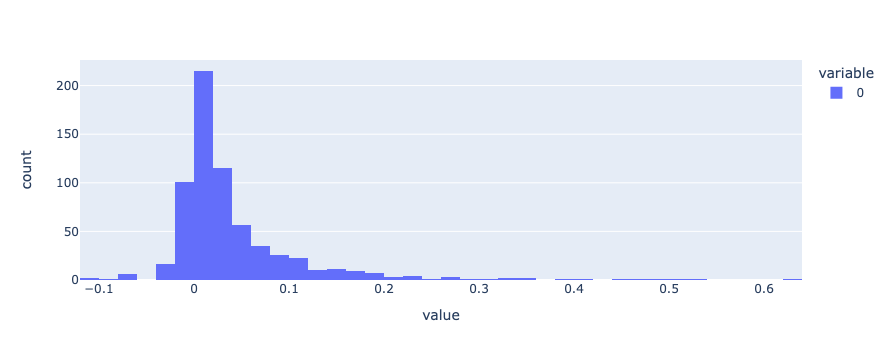

In [110]:
px.histogram(profits)

In [111]:
np.mean(profits), np.sum(profits)

(0.04168133535660092, 27.468000000000007)

### 決済までの時間

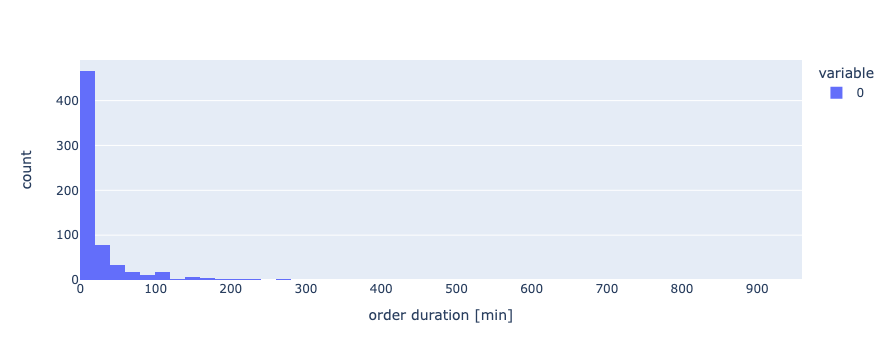

In [112]:
timedeltas = pd.Series([order.exit_timestamp - order.entry_timestamp for order in order_manager.order_history])
fig = px.histogram(timedeltas.dt.seconds // 60)
fig.update_layout(xaxis_title="order duration [min]")

In [113]:
timedeltas.min(), timedeltas.median(), timedeltas.mean(), timedeltas.max()

(Timedelta('0 days 00:01:00'),
 Timedelta('0 days 00:13:00'),
 Timedelta('0 days 00:33:56.267071320'),
 Timedelta('0 days 15:48:00'))

### 取引の可視化

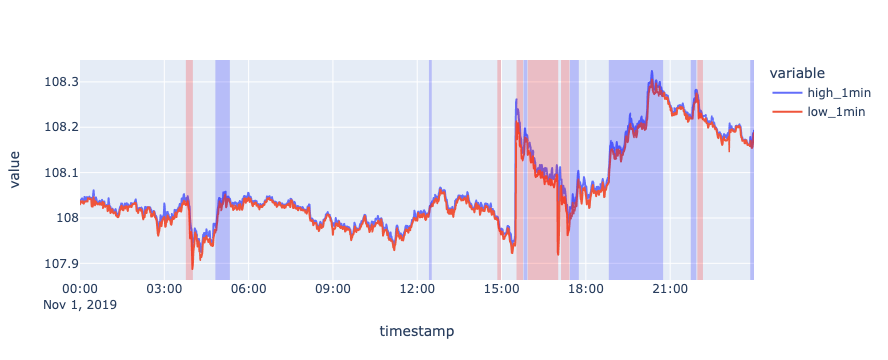

In [114]:
plot_date = "2019-11-01"
start_datetime = pd.Timestamp(plot_date + " 00:00:00")
end_datetime = pd.Timestamp(plot_date + " 23:59:59")

fig = px.line(df.loc[plot_date, ["high_1min", "low_1min"]])

for order in order_manager.order_history:
    if order.entry_timestamp < start_datetime or order.exit_timestamp > end_datetime:
        continue

    fillcolor = "blue" if order.position_type == "long" else "red"
    fig.add_vrect(x0=order.entry_timestamp, x1=order.exit_timestamp, line_width=0, opacity=0.2, fillcolor=fillcolor)

fig.show()

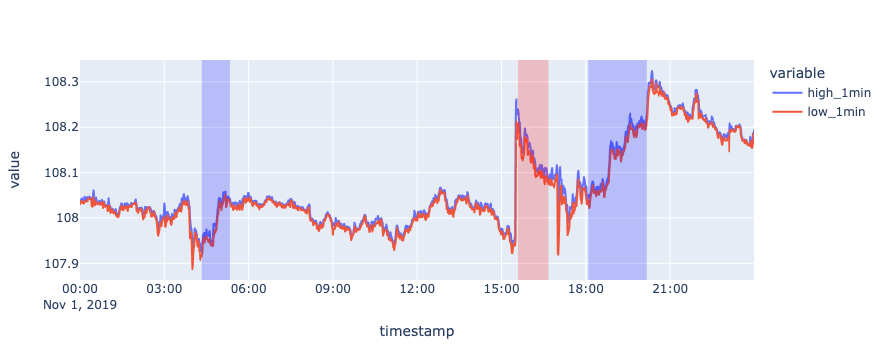

In [115]:
freq = "5min"
uptrend = df.loc[plot_date, f"uptrend_{freq}"]
downtrend = df.loc[plot_date, f"downtrend_{freq}"]

fig = px.line(df.loc[plot_date, ["high_1min", "low_1min"]])
plot_bool_series(fig, uptrend, "blue")
plot_bool_series(fig, downtrend, "red")
fig.show()

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94200 entries, 2019-10-01 00:00:00 to 2019-12-31 23:59:00
Data columns (total 46 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open_1min        94200 non-null  float64
 1   high_1min        94200 non-null  float64
 2   low_1min         94200 non-null  float64
 3   close_1min       94200 non-null  float64
 4   uptrend_1min     94200 non-null  bool   
 5   downtrend_1min   94200 non-null  bool   
 6   open_5min        94200 non-null  float64
 7   high_5min        94200 non-null  float64
 8   low_5min         94200 non-null  float64
 9   close_5min       94200 non-null  float64
 10  uptrend_5min     94200 non-null  bool   
 11  downtrend_5min   94200 non-null  bool   
 12  open_15min       94200 non-null  float64
 13  high_15min       94200 non-null  float64
 14  low_15min        94200 non-null  float64
 15  close_15min      94200 non-null  float64
 16  uptrend_15min    94200 

In [87]:
year = 5
lag = 20
factor = 1/2 /2
print(25 * 4 * year * lag * factor / 1000, "GB")

2.5 GB
